<a href="https://colab.research.google.com/github/hieubkset/Colab-Notebooks/blob/master/data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kỹ thuật Data Augmetation**

Trong bài [Overfitting và Underfitting](https://ezcodin.com/tf06), chúng ta đã tìm hiểu hai kỹ thuật tránh overfitting là **regularization** và **dropout**. Trong bài này, chúng ta sẽ tìm hiểu thêm một kỹ thuật tránh overfitting rất hiệu quả là **Data Augmentation**.

Một trong các nguyên nhân dẫn tới overfitting là do có ít dữ liệu để train model. **Data Augmentation** giải quyết vấn đề này bằng cách tạo thêm dữ liệu từ tập dữ liệu có sẵn bằng các cách như: lật hình, xoay hình, dịch, thu phóng, v.v.

Mục tiêu:

+ Học cách sử dụng ImageDataGenerator để load ảnh từ ổ đĩa.
+ Học cách áp dụng Data Augmentation với ImageDataGenerator.

## Chương trình

### 1. Khai báo thư viện và tham số

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


**Các thư viện:**

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

import os
import pathlib

**Tham số:**

In [0]:
epochs = 30
batch_size = 128
img_width = img_height = 144

### 2. Chuẩn bị dữ liệu

Chúng ta sẽ sử dụng bộ dữ liệu **cats and dogs** để làm ví dụ.

**Tải dữ liệu:**

In [0]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = keras.utils.get_file('cats_and_dogs.zip', _URL, extract=True, )

Dữ liệu sau khi giải nén được tổ chức như sau:
<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

**Đếm số lượng ảnh cho training và validation:**

Note: vì khi gọi `model.fit` ta cần truyền vào hai tham số `steps_per_epoch` và `validation_steps`. Trong đó: $steps\_per\_epoch = total\_train\_images : batch\_size$ và $validation\_steps = total\_validation\_images : batch\_size$. 

In [0]:
data_dir = pathlib.Path(os.path.dirname(path_to_zip))/'cats_and_dogs_filtered'
train_dir = data_dir/'train'
train_cats_dir = train_dir/'cats'
train_dogs_dir = train_dir/'dogs'

val_dir = data_dir/'validation'
val_cats_dir = val_dir/'cats'
val_dogs_dir = val_dir/'dogs'

In [6]:
num_cat_train = len(os.listdir(train_cats_dir))
num_dog_train = len(os.listdir(train_dogs_dir))
num_cat_val = len(os.listdir(val_cats_dir))
num_dog_val = len(os.listdir(val_dogs_dir))
total_train_img = num_cat_train + num_dog_train
total_val_img = num_cat_val + num_dog_val

print('total training cat images: ', num_cat_train)
print('total training dog images: ', num_dog_train)
print('total validation cat images: ', num_cat_val)
print('total validation dog images: ', num_dog_val)
print('---')
print('total training images: ', total_train_img)
print('total validation images: ', total_val_img)

total training cat images:  1000
total training dog images:  1000
total validation cat images:  500
total validation dog images:  500
---
total training images:  2000
total validation images:  1000


**Sử dụng `ImageDataGenerator` để đọc dữ liệu từ ổ đĩa:**

*Note: `ImageDataGenerator` yêu cầu mỗi thư mục trong `train_dir` tương ứng với một class. Bộ dữ liệu chúng ta tải về từ `_URL` đã được tổ chức theo đúng định dạng này nên chúng ta không cần phải thao tác thêm.*

In [7]:
train_img_gen = ImageDataGenerator(rescale=1./255)
train_img_gen = train_img_gen.flow_from_directory(train_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  class_mode='binary')

val_img_gen = ImageDataGenerator(rescale=1./255)
val_img_gen = val_img_gen.flow_from_directory(val_dir,
                                              target_size=(img_height, img_width),
                                              batch_size=batch_size,
                                              shuffle=False,
                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**Chúng ta sẽ hiển thị một vài bức ảnh để về dữ liệu cần phân loại:**

In [0]:
def plot_images(images):
    plt.figure(figsize=(15, 3))
    for i, img in enumerate(images):
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

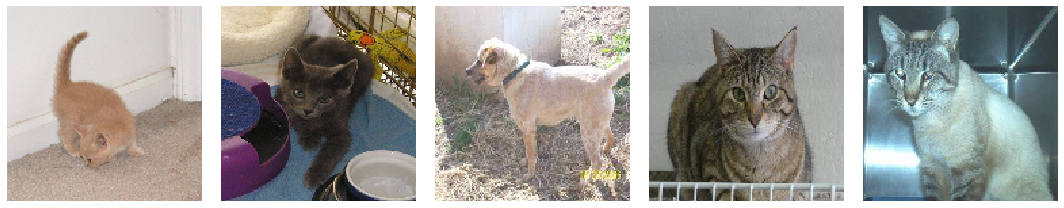

In [9]:
sample_images = next(train_img_gen)[0]
plot_images(sample_images[:5])

### 3. Khai báo model, training và vẽ learning curve

In [0]:
def get_model():
    model = Sequential()
    model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='Adam',
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    
    return model

In [0]:
model = get_model()

model.summary()

history = model.fit(train_img_gen,
          epochs=epochs,
          steps_per_epoch=total_train_img//batch_size,
          validation_data=val_img_gen,
          validation_steps=total_val_img//batch_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 144, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       7

**Vẽ learning curve:**

In [0]:
def plot_learning_curve(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(loc='lower right')
    
    plt.show()

In [0]:
plot_learning_curve(history)

Nhìn vào learning curve, chúng ta có thể thấy model nhanh trong bị overfitting. 

### 4. Data Augmentation

Sử dụng `ImageDataGenerator` chúng ta có thể áp dụng các phương pháp data augmentation lên dữ liệu ảnh như: lật ngang (horizontal flip), lật dọc (vertical flip), xoay ảnh (rotation), dịch ảnh (shift), thu phóng ảnh, v.v.

**Lật ngang:**

In [0]:
img_gen = ImageDataGenerator(rescale=1./255,
                             horizontal_flip=True)
img_gen = img_gen.flow_from_directory(train_dir,
                                      target_size=(img_height, img_width),
                                      batch_size=batch_size,
                                      shuffle=True,
                                      class_mode='binary')
sample_images = [img_gen[3][0][127] for _ in range(5)]
plot_images(sample_images)

**Xoay ảnh:**

In [0]:
img_gen = ImageDataGenerator(rescale=1./255,
                             rotation_range=45)
img_gen = img_gen.flow_from_directory(train_dir,
                                      target_size=(img_height, img_width),
                                      batch_size=batch_size,
                                      shuffle=True,
                                      class_mode='binary')
sample_images = [img_gen[3][0][127] for _ in range(5)]
plot_images(sample_images)

**Thu phóng ảnh:**

In [0]:
img_gen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.5)
img_gen = img_gen.flow_from_directory(train_dir,
                                      target_size=(img_height, img_width),
                                      batch_size=batch_size,
                                      shuffle=True,
                                      class_mode='binary')
sample_images = [img_gen[3][0][127] for _ in range(5)]
plot_images(sample_images)

**Sử dụng kết hợp các phương pháp data augmentation:**

In [0]:
train_img_gen = ImageDataGenerator(rescale=1./255,
                             horizontal_flip=True,
                             rotation_range=45,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             zoom_range=0.5)
train_img_gen = train_img_gen.flow_from_directory(train_dir,
                                      target_size=(img_height, img_width),
                                      batch_size=batch_size,
                                      shuffle=True,
                                      class_mode='binary')
sample_images = [img_gen[3][0][127] for _ in range(5)]
plot_images(sample_images)

Lưu ý: ta chỉ áp dụng data augmentation đối với training data.

In [0]:
val_img_gen = ImageDataGenerator(rescale=1./255)
val_img_gen = val_img_gen.flow_from_directory(val_dir,
                                              target_size=(img_height, img_width),
                                              batch_size=batch_size,
                                              shuffle=False,
                                              class_mode='binary')

**Training với augmented data:**

In [0]:
model = get_model()

history = model.fit(train_img_gen,
          epochs=epochs,
          steps_per_epoch=total_train_img//batch_size,
          validation_data=val_img_gen,
          validation_steps=total_val_img//batch_size)

**Learning curve:**

In [0]:
plot_learning_curve(history)

Chúng ta có thể thấy vấn đề overfitting đã được cải thiện đáng kể, accuracy của model sẽ tiếp tục tăng nếu chúng ta tiếp tục training.